# Starting up

In [ ]:
!nvidia-smi

Fri Sep  4 21:03:26 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.66       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   46C    P8     9W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import gc
gc.collect()

15

In [ ]:
import torch
import torchvision.models as models
import torch.nn as nn
import torch.utils
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt
import fastai
from fastai.vision import *
from fastai.callbacks import *

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image

In [ ]:
import random
import re
from tqdm import tqdm, trange
from math import inf

In [ ]:
from tqdm.notebook import tqdm

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import warnings
warnings.filterwarnings("ignore")

# Paths

In [ ]:
path = Path("drive/My Drive/train_dataset")
models_path = path/'models'
noon_path = Path('drive/My Drive/ToDayGAN/datasets/train/train0/noon 3085/00/image_0')
night_path = Path('drive/My Drive/ToDayGAN/datasets/train/train1/night 3085/00/image_0')
weird_night_path = Path('drive/My Drive/Night/00/image_0')
dump_path = path / 'dump'

In [ ]:
new_path = Path('drive/My Drive/Dataset Carla')
new_images_path = new_path/ 'generated_images'
new_models_path = new_path/ 'models'

# Dataloader

In [ ]:
tfms = get_transforms(do_flip=False, max_rotate=0.0, max_warp= 0.0)

In [ ]:
keep_pct = 1
data = (ImageList.from_folder(new_images_path)
        .use_partial_data(keep_pct)
        .split_by_rand_pct(valid_pct=0.15, seed=42)
        .label_from_folder()
        .transform(tfms, size=(448, 224))
        .databunch(bs=64)) 

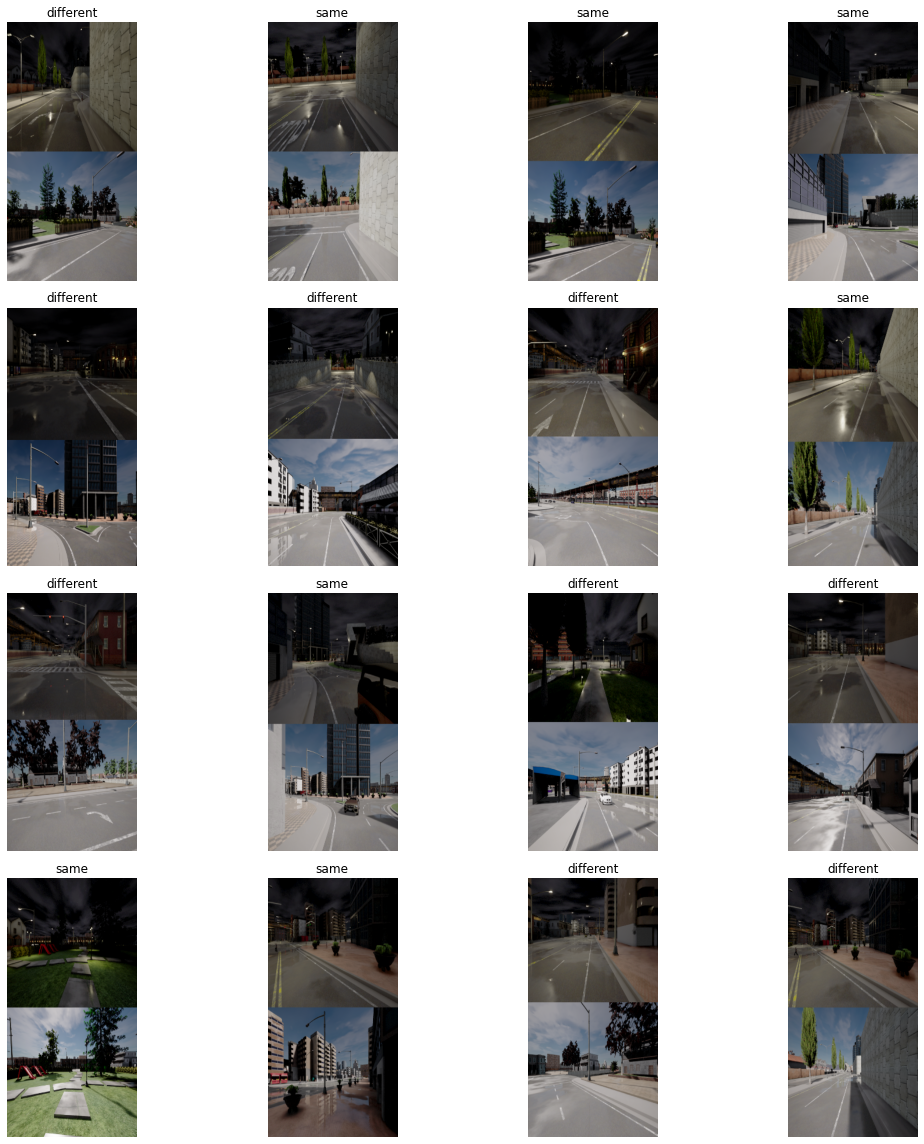

In [ ]:
data.show_batch(4)

# Model

In [ ]:
def conv3x3(in_planes, out_planes, stride=1, groups=1, dilation=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=dilation, groups=groups, bias=False, dilation=dilation)

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, groups=1,
                 base_width=64, dilation=1, norm_layer=None):
        super(BasicBlock, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        if groups != 1 or base_width != 64:
            raise ValueError('BasicBlock only supports groups=1 and base_width=64')
        if dilation > 1:
            raise NotImplementedError("Dilation > 1 not supported in BasicBlock")
        # Both self.conv1 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv3x3(inplanes, inplanes, stride)
        self.bn1 = norm_layer(inplanes)
        self.relu = nn.ReLU(inplace=False)
        self.conv2 = conv3x3(inplanes, planes)
        self.bn2 = norm_layer(planes)
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        
        out += identity

        out = self.conv2(out)
        out = self.bn2(out)
        
        out = self.relu(out)

        return out

In [ ]:
class YModel(torch.nn.Module):
    def __init__(self):
        """
        """
        super(YModel, self).__init__()
        self.top_half = nn.Sequential(*list(models.resnet34(pretrained=True).children())[:6])
        self.bot_half = nn.Sequential(*list(models.resnet34(pretrained=True).children())[:6])
        self.neck = BasicBlock(256, 128)
        self.second_half = nn.Sequential(*list(models.resnet34(pretrained=True).children())[6:-1])
        self.fc1 = nn.Linear(512, 2)

    def forward(self, img):
        """
        """
        partition = img.shape[2] // 2
        img_1, img_2 = img[:,:,:partition,:], img[:,:,partition:,:]
        top_features = self.top_half(img_1)
        bot_features = self.bot_half(img_2)

        concat_features = torch.cat((top_features, bot_features), 1)

        second_half_input = self.neck(concat_features)
        out = self.second_half(second_half_input)
        out = torch.flatten(out, 1)
        out = self.fc1(out)
        out = nn.functional.softmax(out, dim=1)

        return out

# Learner



In [ ]:
y_model = Learner(data, YModel(), AdamW, metrics=accuracy)

In [ ]:
y_model.load('final_scratch_20_30');

### Run the following only for training

In [ ]:
y_model.unfreeze()

In [ ]:
y_model.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


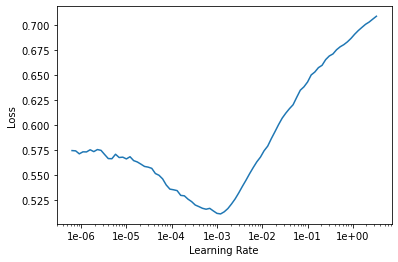

In [ ]:
y_model.recorder.plot()

In [ ]:
y_model.fit_one_cycle(10, max_lr=1e-4, callbacks=[SaveModelCallback(y_model, every='improvement', monitor='valid_loss', name='final_pretrain_inference_10')])

epoch,train_loss,valid_loss,accuracy,time
0,0.568252,0.495750,0.824561,00:57
1,0.554685,0.476521,0.824561,00:39
2,0.521261,0.514032,0.771930,00:39
3,0.496613,0.748401,0.561404,00:38
4,0.477343,0.570420,0.736842,00:38
5,0.465534,0.481520,0.824561,00:38
6,0.456644,0.492280,0.807018,00:38
7,0.447768,0.487199,0.824561,00:37
8,0.439611,0.486604,0.824561,00:38
9,0.434597,0.489343,0.824561,00:37


Better model found at epoch 0 with valid_loss value: 0.49574995040893555.
Better model found at epoch 1 with valid_loss value: 0.47652071714401245.


In [ ]:
y_model.fit_one_cycle(10, max_lr=1e-4, callbacks=[SaveModelCallback(y_model, every='improvement', monitor='valid_loss', name='final_pretrain_inference_10_20')])

epoch,train_loss,valid_loss,accuracy,time
0,0.488779,0.463218,0.842105,00:40
1,0.479188,0.482764,0.842105,00:39
2,0.463061,0.536734,0.771930,00:38
3,0.451910,0.509559,0.789474,00:38
4,0.443971,0.501598,0.789474,00:38
5,0.436545,0.491274,0.807018,00:38
6,0.429440,0.461543,0.842105,00:38
7,0.424429,0.460641,0.842105,00:38
8,0.418671,0.455951,0.859649,00:38
9,0.415892,0.456038,0.842105,00:37


Better model found at epoch 0 with valid_loss value: 0.463217556476593.
Better model found at epoch 6 with valid_loss value: 0.46154314279556274.
Better model found at epoch 7 with valid_loss value: 0.4606409966945648.
Better model found at epoch 8 with valid_loss value: 0.45595070719718933.


In [ ]:
y_model.fit_one_cycle(10, max_lr=1e-5, callbacks=[SaveModelCallback(y_model, every='improvement', monitor='valid_loss', name='final_scratch_20_30')])

epoch,train_loss,valid_loss,accuracy,time
0,0.318811,0.334244,0.978836,04:25
1,0.318605,0.333107,0.978836,04:27
2,0.318313,0.333833,0.981481,04:25
3,0.318246,0.332259,0.981481,04:24
4,0.317953,0.331231,0.981481,04:25
5,0.317372,0.332164,0.981481,04:23
6,0.317151,0.332557,0.981481,04:22
7,0.317414,0.333418,0.978836,04:24
8,0.317388,0.332981,0.978836,04:27


Better model found at epoch 0 with valid_loss value: 0.3342441916465759.
Better model found at epoch 1 with valid_loss value: 0.33310651779174805.
Better model found at epoch 3 with valid_loss value: 0.33225902915000916.
Better model found at epoch 4 with valid_loss value: 0.33123138546943665.


# Interpretation (Optional)

In [ ]:
preds,y,losses = y_model.get_preds(with_loss=True)
interp = ClassificationInterpretation(y_model, preds, y, losses)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


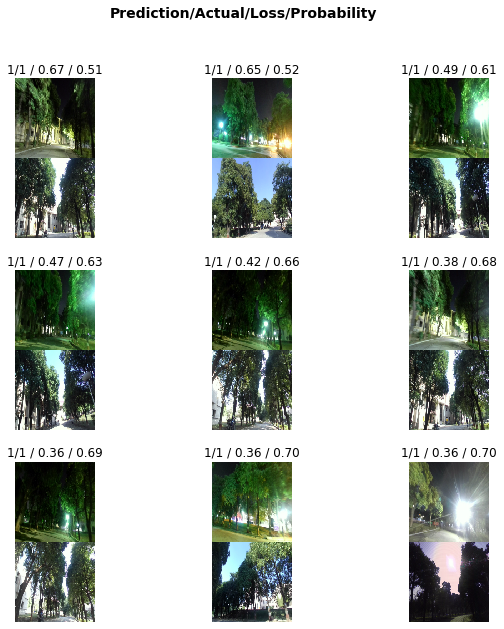

In [ ]:
interp.plot_top_losses(9, figsize=(10,10))

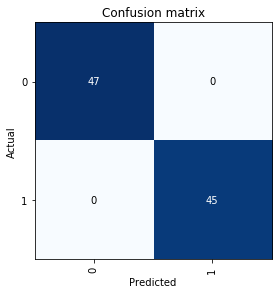

In [ ]:
interp.plot_confusion_matrix()

# Functions for prediction

In [ ]:
def get_fastai_image_from_PIL(image, div:bool=True, convert_mode:str='RGB', cls:type=fastai.vision.Image,
        after_open:Callable=None)->Image:
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", UserWarning) # EXIF warning from TiffPlugin
        x = image.convert(convert_mode)
    if after_open: x = after_open(x)
    x = pil2tensor(x,np.float32)
    if div: x.div_(255)
    return x

In [ ]:
def get_concatenated_image(image1, image2):
  image1_array = np.array(image1)
  image2_array = np.array(image2)
  image_concatenated = np.concatenate([image1_array, image2_array], axis=0)
  return Image.fromarray(image_concatenated)

In [ ]:
class ImageTuple(ItemBase):
    def __init__(self, img1, img2):
        self.img1,self.img2 = img1,img2
        self.obj,self.data = (img1,img2),get_concatenated_image(img1,img2)

In [ ]:
class ImageTupleList(ImageList):
    def __init__(self, items, itemsB=None, **kwargs):
        super().__init__(items, **kwargs)
        self.itemsB = itemsB
        self.copy_new.append('itemsB')
    
    def get(self, i):
        img1 = super().get(i)
        fn = self.itemsB[random.randint(0, len(self.itemsB)-1)]
        return ImageTuple(img1, open_image(fn))
    
    def reconstruct(self, t:Tensor): 
        return ImageTuple(Image(t[0]/2+0.5),Image(t[1]/2+0.5))
    
    @classmethod
    def from_folders(cls, path, folderA, folderB, **kwargs):
        itemsB = ImageList.from_folder(path/folderB).items
        res = super().from_folder(path/folderA, itemsB=itemsB, **kwargs)
        res.path = path
        return res

In [ ]:
def get_prediction(model, image1, image2):
  concatenated_image = get_concatenated_image(image1, image2)
  img = get_fastai_image_from_PIL(concatenated_image)
  return model.predict(img)[2]

In [ ]:
def get_sequence_similarity_score(model, seq1, seq2):
  total = 0
  for img1, img2 in zip(seq1, seq2):
    total += get_prediction(model, img1, img2)[1]
  return total    

# One random image

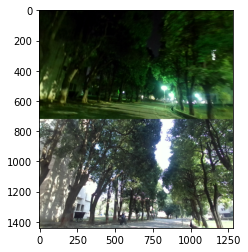

In [ ]:
one_random_image = Image.open('drive/My Drive/train_dataset/1/1000.png')
image_list = [one_random_image]
plt.imshow(one_random_image)

# Helper functions

In [ ]:
bracket_regex = re.compile(r'\((.*)\)')

In [ ]:
def get_image_number_from_filename(filename):
  return int(bracket_regex.search(str(filename)).group(1))

def get_image_filename_from_number(number):
  return noon_path/f'l ({number}).png'

In [ ]:
bin_size = 50
sequence_size = 5

In [ ]:
# Bins (Temporary)

def get_bin_number_from_image_number(image_number, bin_size=bin_size):
  return image_number // bin_size

def get_image_number_from_bin_number(bin_number, bin_size=bin_size):
  return (bin_number * bin_size) + 1

def get_closest_bin_image_number(image_number, bin_size=bin_size):
  return get_image_number_from_bin_number(get_bin_number_from_image_number(image_number, bin_size))

def get_next_closest_bin_image_number(image_number, bin_size=bin_size):
  return get_image_number_from_bin_number(get_bin_number_from_image_number(image_number, bin_size) + 1)

# Load images from database

In [ ]:
n = len(os.listdir(noon_path))
arr = sorted(os.listdir(noon_path), key=get_image_number_from_filename)
all_noon_bin_sequence_images = list()
for i in tqdm(range(0, len(arr), bin_size)):
  all_noon_bin_sequence_images.append([Image.open(noon_path/image) for image in arr[i: i + sequence_size]])

In [ ]:
# Load all bin images

all_noon_bin_images = [Image.open(noon_path/image) for image in tqdm(sorted(os.listdir(noon_path), key=get_image_number_from_filename)[::bin_size])]

In [ ]:
# Load all night images

all_night_images = [Image.open(night_path/image) for image in tqdm(sorted(os.listdir(night_path), key=get_image_number_from_filename)[:2000])]

In [ ]:
# Load all night images having gaussian noise
gaussian_night_path = Path('drive/My Drive/ToDayGAN/datasets/train/night_gaussian')
all_night_images = [Image.open(gaussian_night_path/image) for image in tqdm(sorted(os.listdir(gaussian_night_path), key=lambda x: int(x[0:-4]))[:2000])]

In [ ]:
len(all_night_images)

2000

In [ ]:
# Load all weird night images

all_weird_night_images = [Image.open(weird_night_path/image) for image in tqdm(sorted(os.listdir(weird_night_path), key=lambda x: int(x))[:2000])]

# Find Landmarks

### Run only once to generate the array of induces

In [ ]:
# from skimage.metrics import structural_similarity

In [ ]:
# def helper(x):
#   idx, image = x
#   ss_sum = 0
#   for i, bin_image in tqdm(enumerate(all_noon_bin_images)):
#     if i != idx:
#       ss_sum += structural_similarity(np.array(image), np.array(bin_image), multichannel=True)
#   return ss_sum

In [ ]:
# landmark_sorted_bins = list(tqdm(sorted(enumerate(all_noon_bin_images), key=helper)))

### Use the following array directly after having run the previous section

In [ ]:
landmark_sorted_indxs = [5, 10, 11, 0, 1, 61, 2, 54, 6, 15, 51, 57, 14, 30, 53, 50, 47, 59, 7, 46, 48, 45, 52, 60, 13, 49, 9, 44, 58, 25, 33, 43, 40, 16, 18, 19, 8, 12, 42, 28, 27, 21, 56, 41, 26, 55, 23, 31, 4, 36, 38, 3, 17, 24, 34, 37, 22, 32, 39, 20, 35, 29]

In [ ]:
landmark_sorted_indxs = [5, 11, 61, 54, 47, 25, 33]

In [ ]:
landmark_sorted_bins = [(i, all_noon_bin_images[i]) for i in landmark_sorted_indxs]

In [ ]:
k_fraction = 1

In [ ]:
landmarks = landmark_sorted_bins[:int(k_fraction * len(landmark_sorted_bins))]

In [ ]:
get_prediction(y_model, all_night_images[200], landmark_sorted_bins[0][1])

tensor([0.7311, 0.2689])

In [ ]:
def global_search_on_landmarks(night_image_seq):
  landmark_threshold = 0.7*sequence_size
  max_similarity = -inf
  max_idx = None
  for idx, _ in landmarks:
    landmark_sequence = all_noon_bin_sequence_images[idx]
    similarity = get_sequence_similarity_score(y_model, night_image_seq, landmark_sequence)
    if similarity > max_similarity and similarity>landmark_threshold:
      max_similarity = similarity
      max_idx = idx
  return max_similarity, max_idx

def local_search_around_landmark(landmark_idx, night_image_seq):
  max_similarity = -inf
  max_idx = None
  similarity = [-inf, -inf, -inf, -inf, -inf]
  for i in range(-2, 3):
    similarity[i] = get_sequence_similarity_score(y_model, night_image_seq, all_noon_bin_sequence_images[(landmark_idx + i) % len(all_noon_bin_sequence_images)])
    if similarity[i] > max_similarity:
      max_similarity = similarity[i]
      max_idx = i + landmark_idx
  return max_similarity, max_idx

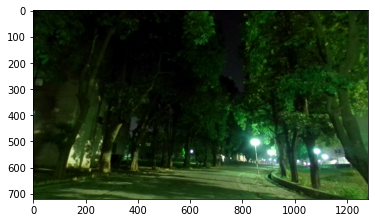

In [ ]:
plt.imshow(all_night_images[0])

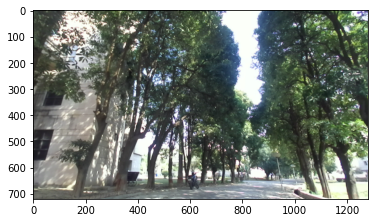

In [ ]:
plt.imshow(all_noon_bin_sequence_images[0][0])

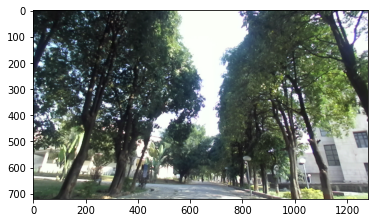

In [ ]:
plt.imshow(all_noon_bin_sequence_images[2][0])

## Landmarks Analysis


In [ ]:
len(landmarks)

7

In [ ]:
def plot_similarity_scores_landmarks():
  _landmarks = [33]
  for idx in _landmarks:
    print("Landmark - ", str(idx))
    graph_arrays = list()
    for i in range(0, len(all_night_images) + sequence_size, 10):
      try:
        night_image_seq = all_night_images[i: i + sequence_size]
        night_image_number = get_image_number_from_filename(all_night_images[i].filename)
        noon_image_bin_number_corresponding_to_current_night_image = get_bin_number_from_image_number(night_image_number)
        landmark_sequence = all_noon_bin_sequence_images[idx]
        similarity = get_sequence_similarity_score(y_model, night_image_seq, landmark_sequence)
        graph_arrays.append((noon_image_bin_number_corresponding_to_current_night_image, similarity))
      except:
        pass
    graph_arrays = np.array(graph_arrays)
    plt.scatter([j[0] for j in graph_arrays], [j[1] for j in graph_arrays])
    plt.xlabel('night image number')
    plt.ylabel('similarity score with')
    plt.show()
  return

Landmark -  33


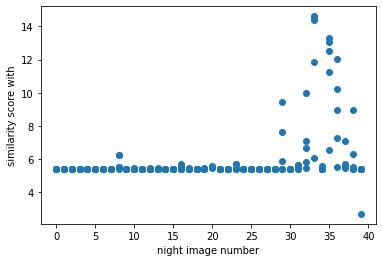

In [ ]:
plot_similarity_scores_landmarks()

Landmark -  5


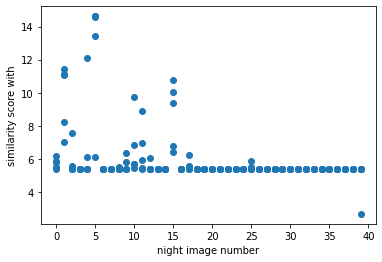

Landmark -  10


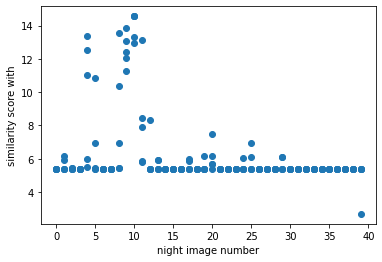

Landmark -  11


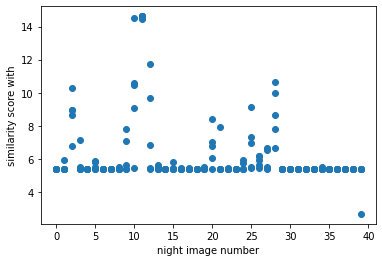

Landmark -  0


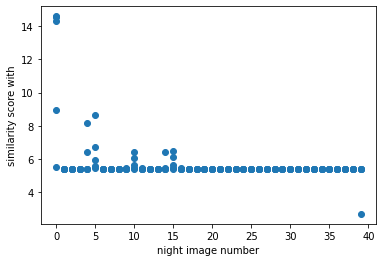

Landmark -  1


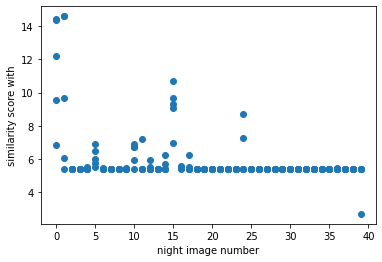

Landmark -  61


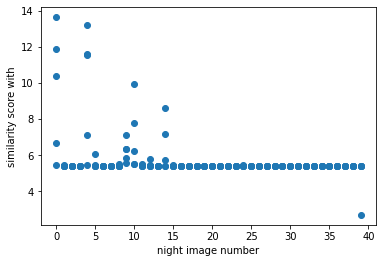

Landmark -  2


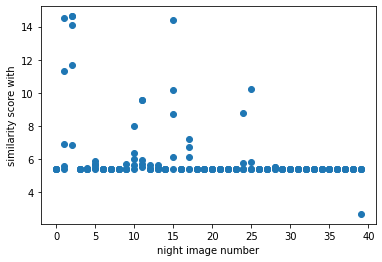

Landmark -  54


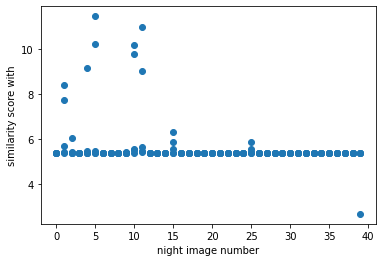

Landmark -  6


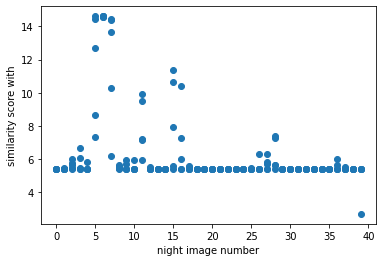

Landmark -  15


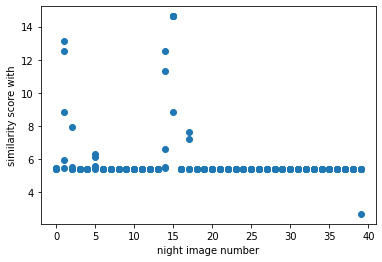

Landmark -  51


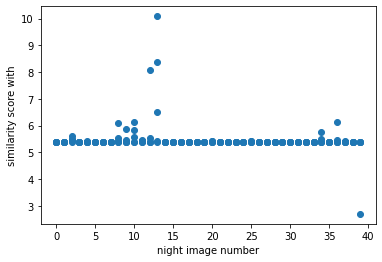

Landmark -  57


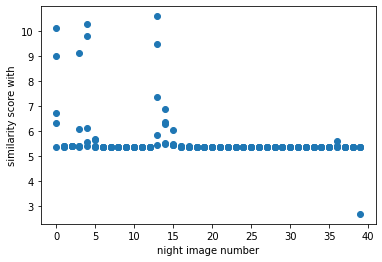

Landmark -  14


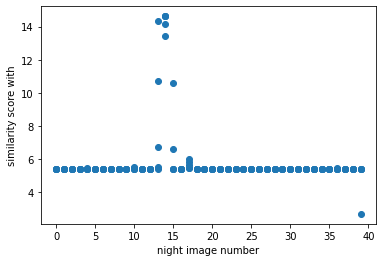

Landmark -  30


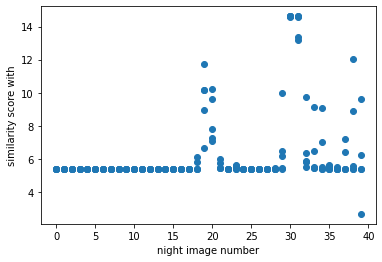

Landmark -  53


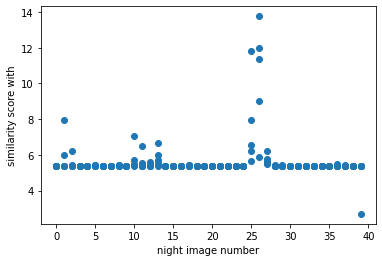

In [ ]:
# seq size = 20
# plot_similarity_scores_landmarks()

In [ ]:
min_val = inf
similarity_scores = list()
for idx, night_image in tqdm(enumerate(all_night_images)):
  corresponding_bin_number = idx // bin_size
  _, similarity_score1 = get_prediction(y_model, night_image, all_noon_bin_images[corresponding_bin_number])
  _, similarity_score2 = get_prediction(y_model, night_image, all_noon_bin_images[corresponding_bin_number + 1])
  similarity_score = max(similarity_score1, similarity_score2)
  similarity_scores.append(similarity_score)

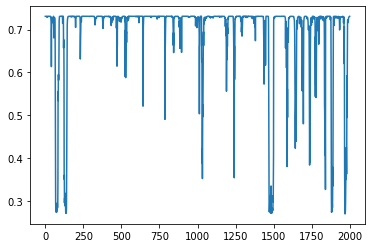

In [ ]:
plt.plot(*zip(*enumerate(similarity_scores)))

In [ ]:
get_prediction(y_model, all_night_images[1000], all_noon_bin_images[0])

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "


tensor([0.7311, 0.2689])

# Accuracy

In [ ]:
base_dump_file = dump_path / 'base_0_2000.npy'
global_search_dump_file = dump_path / 'global_search_0_2000.npy'
local_thres_dump_file = dump_path / 'local_thres_0_2000.npy'

base_tail_dump_file = dump_path / 'base_2001_3000.npy'
global_tail_search_dump_file = dump_path / 'global_search_2001_3000.npy'
local_tail_thres_dump_file = dump_path / 'local_thres_2001_3000.npy'

base_dump_file_15  = dump_path / 'base_0_2000_15.npy'
base_dump_file_15_gaussian  = dump_path / 'base_0_2000_15_gaussian.npy'

global_dump_file_10  = dump_path / 'global_0_2000_10.npy'


base_dump_file_1  = dump_path / 'base_0_2000_1.npy'
global_dump_file_1  = dump_path / 'global_0_2000_1.npy'

base_dump_file_5  = dump_path / 'base_0_2000_5.npy'
global_dump_file_5  = dump_path / 'global_0_2000_5.npy'

In [ ]:
# Base
def find_new_accuracy_base():
  curr_noon_image_bin_number = 0
  error = 0
  graph_arrays = list()
  # graph_arrays = list(graph_arrays)
  for i in range(len(all_night_images) + sequence_size):
    
    
    try:
      night_image_seq = all_night_images[i: i + sequence_size]
      night_image_number = get_image_number_from_filename(all_night_images[i].filename)
      # night_image_number = int(all_night_images[i].filename.split('/')[-1][0:-4]) # for gaussian images
      noon_image_bin_number_corresponding_to_current_night_image = get_bin_number_from_image_number(night_image_number)
      similarity1 = get_sequence_similarity_score(y_model, night_image_seq, all_noon_bin_sequence_images[curr_noon_image_bin_number])
      similarity2 = get_sequence_similarity_score(y_model, night_image_seq, all_noon_bin_sequence_images[(curr_noon_image_bin_number + 1) % len(all_noon_bin_sequence_images)])
      
      if similarity2 > similarity1:
        curr_noon_image_bin_number = (curr_noon_image_bin_number + 1) % len(all_noon_bin_sequence_images)
      
      if abs(curr_noon_image_bin_number - noon_image_bin_number_corresponding_to_current_night_image) >= 2:
        error += 1

      graph_arrays.append((error, noon_image_bin_number_corresponding_to_current_night_image, curr_noon_image_bin_number))
    except:
      print('error', str(i))
      pass
    
    if i % 100 == 0: 
      print(f'Error: {error}, Current Night Image Number: {night_image_number}, Current Day Image Bin Number: {curr_noon_image_bin_number}')
      np.save(base_dump_file_5, graph_arrays) 
  return graph_arrays

In [ ]:
graph_arrays = find_new_accuracy_base()

Error: 0, Current Night Image Number: 1, Current Day Image Bin Number: 0
Error: 0, Current Night Image Number: 101, Current Day Image Bin Number: 2
Error: 0, Current Night Image Number: 201, Current Day Image Bin Number: 4
Error: 0, Current Night Image Number: 301, Current Day Image Bin Number: 6
Error: 0, Current Night Image Number: 401, Current Day Image Bin Number: 8
Error: 0, Current Night Image Number: 501, Current Day Image Bin Number: 10
Error: 0, Current Night Image Number: 601, Current Day Image Bin Number: 12
Error: 0, Current Night Image Number: 701, Current Day Image Bin Number: 14
Error: 0, Current Night Image Number: 801, Current Day Image Bin Number: 16
Error: 0, Current Night Image Number: 901, Current Day Image Bin Number: 18
Error: 0, Current Night Image Number: 1001, Current Day Image Bin Number: 20
Error: 69, Current Night Image Number: 1101, Current Day Image Bin Number: 23
Error: 69, Current Night Image Number: 1201, Current Day Image Bin Number: 24
Error: 69, Cur

In [ ]:
np.save(base_dump_file_5, graph_arrays) 

In [ ]:
len(graph_arrays)

2000

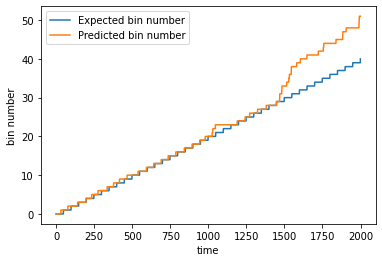

In [ ]:
plt.plot([i for i in range(len(graph_arrays))], [i[1] for i in graph_arrays], label='Expected bin number')
plt.plot([i for i in range(len(graph_arrays))], [i[2] for i in graph_arrays], label='Predicted bin number')
plt.xlabel('time')
plt.ylabel('bin number')
plt.legend()

In [ ]:
# local_threshold + global search

def find_new_accuracy_local_global():
  curr_noon_image_bin_number = 0
  error = 0
  graph_arrays = list()
  for i in range(len(all_night_images) + sequence_size):
    try:
      night_image_seq = all_night_images[i: i + sequence_size]
      night_image_number = get_image_number_from_filename(all_night_images[i].filename)
      noon_image_bin_number_corresponding_to_current_night_image = get_bin_number_from_image_number(night_image_number)

      similarity1 = get_sequence_similarity_score(y_model, night_image_seq, all_noon_bin_sequence_images[curr_noon_image_bin_number])
      similarity2 = get_sequence_similarity_score(y_model, night_image_seq, all_noon_bin_sequence_images[(curr_noon_image_bin_number + 1) % len(all_noon_bin_sequence_images)])

      similarity_from_landmark_search = -inf
      if max(similarity1, similarity2) < 0.7*sequence_size:
        similarity_from_landmark_search, landmark_bin = global_search_on_landmarks(night_image_seq)
      if similarity_from_landmark_search >= max(similarity1, similarity2):
        print('Landmark wins', str(landmark_bin))
        
        #comment following line to remove the local search around the landmark (does not effect the results)
        _, landmark_bin = local_search_around_landmark(landmark_bin, night_image_seq)
        print('Landmark received', str(landmark_bin))
        curr_noon_image_bin_number = landmark_bin
        print(f'Error: {error}, Current Night Image Number: {night_image_number}, Current Day Image Bin Number: {curr_noon_image_bin_number}')
      elif similarity2 > similarity1:
        curr_noon_image_bin_number = (curr_noon_image_bin_number + 1) % len(all_noon_bin_sequence_images)
      if abs(curr_noon_image_bin_number - noon_image_bin_number_corresponding_to_current_night_image) >= 2:
        error += 1
      graph_arrays.append((error, noon_image_bin_number_corresponding_to_current_night_image, curr_noon_image_bin_number))
    except Exception as e: 
      print('exception -')
      print(e)
      pass
    if i % 100 == 0: 
      print(f'Error: {error}, Current Night Image Number: {night_image_number}, Current Day Image Bin Number: {curr_noon_image_bin_number}')
      np.save(global_dump_file_5, graph_arrays) 
    
  return graph_arrays

In [ ]:
graph_arrays = find_new_accuracy_local_global()

Error: 0, Current Night Image Number: 1, Current Day Image Bin Number: 0
Error: 0, Current Night Image Number: 101, Current Day Image Bin Number: 2
Error: 0, Current Night Image Number: 201, Current Day Image Bin Number: 4
Landmark wins 61
Landmark received 61
Error: 0, Current Night Image Number: 234, Current Day Image Bin Number: 61
Landmark wins 5
Landmark received 5
Error: 3, Current Night Image Number: 237, Current Day Image Bin Number: 5
Error: 3, Current Night Image Number: 301, Current Day Image Bin Number: 6
Error: 3, Current Night Image Number: 401, Current Day Image Bin Number: 8
Error: 3, Current Night Image Number: 501, Current Day Image Bin Number: 10
Landmark wins 61
Landmark received 61
Error: 3, Current Night Image Number: 525, Current Day Image Bin Number: 61
Landmark wins 11
Landmark received 10
Error: 14, Current Night Image Number: 536, Current Day Image Bin Number: 10
Error: 14, Current Night Image Number: 601, Current Day Image Bin Number: 12
Error: 14, Current N

In [ ]:
np.save(global_dump_file_5, graph_arrays) 

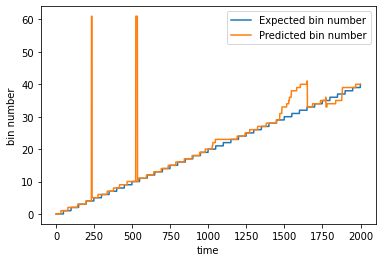

In [ ]:
plt.plot([i for i in range(len(graph_arrays))], [i[1] for i in graph_arrays], label='Expected bin number')
plt.plot([i for i in range(len(graph_arrays))], [i[2] for i in graph_arrays], label='Predicted bin number')
plt.xlabel('time')
plt.ylabel('bin number')
plt.legend()

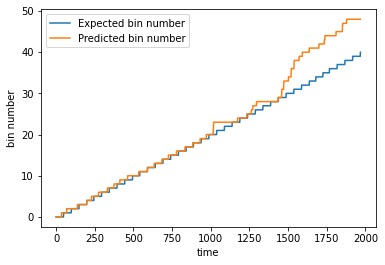

In [ ]:
plt.plot([i for i in range(len(graph_arrays))], [i[1] for i in graph_arrays], label='Expected bin number')
plt.plot([i for i in range(len(graph_arrays))], [i[2] for i in graph_arrays], label='Predicted bin number')
plt.xlabel('time')
plt.ylabel('bin number')
plt.legend()

In [ ]:
# only global

def find_new_accuracy_with_landmarks():
  curr_noon_image_bin_number = 0
  error = 0
  graph_arrays = list()
  for i in range(len(all_night_images) + sequence_size):
    try:
      night_image_seq = all_night_images[i: i + sequence_size]
      night_image_number = get_image_number_from_filename(all_night_images[i].filename)
      noon_image_bin_number_corresponding_to_current_night_image = get_bin_number_from_image_number(night_image_number)

      similarity1 = get_sequence_similarity_score(y_model, night_image_seq, all_noon_bin_sequence_images[curr_noon_image_bin_number])
      similarity2 = get_sequence_similarity_score(y_model, night_image_seq, all_noon_bin_sequence_images[(curr_noon_image_bin_number + 1) % len(all_noon_bin_sequence_images)])
      similarity_from_landmark_search, landmark_bin = global_search_on_landmarks(night_image_seq)

      if similarity_from_landmark_search >= max(similarity1, similarity2):
        print('Landmark wins')
        #comment following line to remove the local search around the landmark (does not effect the results)
        _, landmark_bin = local_search_around_landmark(landmark_bin, night_image_seq)
        curr_noon_image_bin_number = landmark_bin
      elif similarity2 > similarity1:
        curr_noon_image_bin_number = (curr_noon_image_bin_number + 1) % len(all_noon_bin_sequence_images)
      if abs(curr_noon_image_bin_number - noon_image_bin_number_corresponding_to_current_night_image) >= 2:
        error += 1
      print(f'Error: {error}, Current Night Image Number: {night_image_number}, Current Day Image Bin Number: {curr_noon_image_bin_number}')
      graph_arrays.append((error, noon_image_bin_number_corresponding_to_current_night_image, curr_noon_image_bin_number))
    except:
      pass
    if i % 100 == 0: np.save(global_search_dump_file, graph_arrays) 
    
  return graph_arrays

In [ ]:
graph_arrays = find_new_accuracy_local_global()

In [ ]:
np.save(global_search_dump_file, graph_arrays) 

In [ ]:
plt.plot([i for i in range(len(graph_arrays))], [i[1] for i in graph_arrays], label='Expected bin number')
plt.plot([i for i in range(len(graph_arrays))], [i[2] for i in graph_arrays], label='Predicted bin number')
plt.xlabel('time')
plt.ylabel('bin number')
plt.legend()